# Denoising Diffusion Probabilistic Models

Original paper: https://arxiv.org/pdf/2006.11239.pdf

Original tutorial: https://youtu.be/a4Yfz2FxXiY

Original collab: https://colab.research.google.com/drive/1sjy9odlSSy0RBVgMTgP7s99NXsqglsUL?usp=sharing

Main idea: Implement a simple diffusion model for generating car images

## 1. Getting the dataset


The [original dataset link](https://ai.stanford.edu/~jkrause/cars/car_dataset.html) is down, so the download option wasn't working in torchvision. `data = torchvision.datasets.StanfordCars(root="../data/", download=True)` returns an HTTP 404 error.


We can get the dataset from Kaggle instead: https://www.kaggle.com/datasets/jessicali9530/stanford-cars-dataset?resource=download
BUT we need to follow the instructions from this quick fix: https://github.com/pytorch/vision/issues/7545#issuecomment-1631441616

Once we have the right folder structure, this notebook expects the `stanford_cars/` directory to be under the `data/` folder:

```
data/
    stanford_cars/
difussion/
    ddpm.ipynb
```

**NOTES:** 
- Had to download files manually from the sources in that comment first! Make sure the directory structure matches what PyTorch expects.
- OG Pytorch code: https://github.com/pytorch/vision/blob/main/torchvision/datasets/stanford_cars.py

In [23]:
import torch
import torchvision
import matplotlib.pyplot as plt
import os
from PIL import Image

from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np

In [24]:
train_data = torchvision.datasets.StanfordCars(root="../data/")
test_data = torchvision.datasets.StanfordCars(root="../data/", split="test")

In [25]:
def show_image_samples(dataset, num_samples=20, cols=4):
    """Plots num_samples image samples from the dataset"""
    plt.figure(figsize=(10, 10))
    for i, img in enumerate(dataset):
        if i == num_samples:
            break
        plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
        plt.imshow(img[0])
        

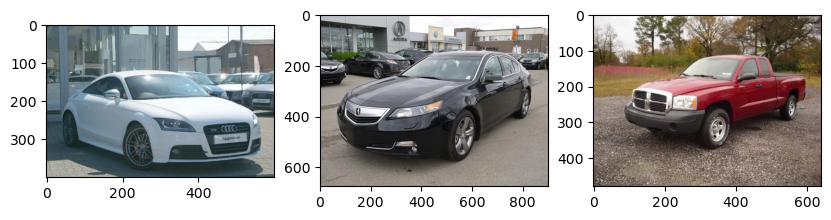

In [26]:
show_image_samples(train_data, num_samples=3, cols=3)

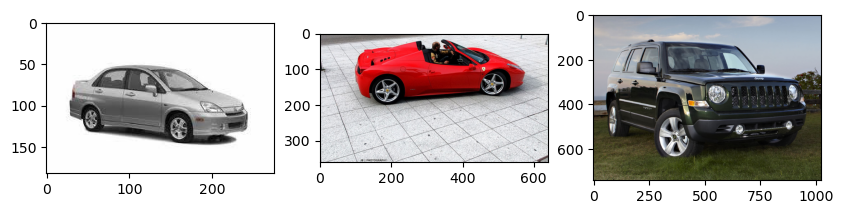

In [27]:
show_image_samples(test_data, num_samples=3, cols=3)

### Data transforms

In [51]:
IMG_SIZE = 64

# PIL -> PyTorch
data_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(), # Scales data into [0, 1]
    transforms.Lambda(lambda t: (t * 2) - 1) # Scales between [-1, 1]
])
    
# PyTorch -> PIL
reverse_transforms = transforms.Compose([
    transforms.Lambda(lambda t: (t + 1) / 2), # Scales from [-1, 1] to [0, 1]
    transforms.Lambda(lambda t: t.permute(1, 2, 0)), # [Channels, Height, Width] to [Height, Width, Channels], which is from PyTorch formatting to NumPy formatting
    transforms.Lambda(lambda t: t * 255.), # Valid PIL image range
    transforms.Lambda(lambda t: t.numpy().astype(np.uint8)), # Valid unsigned integer data format
    transforms.ToPILImage(),
])

def load_transformed_dataset(data_transforms):
    train = torchvision.datasets.StanfordCars(root="../data/", transform=data_transforms)
    test = torchvision.datasets.StanfordCars(root="../data/", split="test", transform=data_transforms)
    return torch.utils.data.ConcatDataset([train, test])

### Load the transformed dataset and create a dataloader

In [52]:
BATCH_SIZE = 128
data = load_transformed_dataset(data_transforms)
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

#### Sample 1 transformed image from the dataset

torch.Size([3, 64, 64])

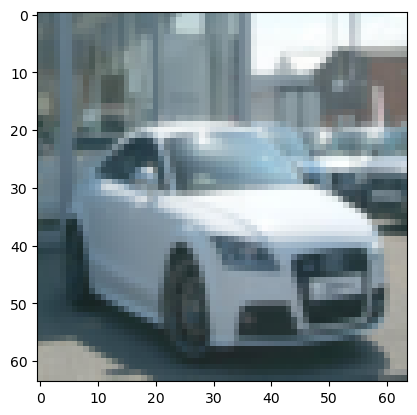

In [53]:
image = data[0][0]
plt.imshow(reverse_transforms(image))
image.shape

## 2. The Forward Process: Adding noise

The forward process of diffusion models consist of a Markov chain that consistently adds Gausian noise to the image based on a variance schedule $\beta_1,...,\beta_T$:

$$q(x_t|x_{t−1}) = N(x_t;\sqrt{1 − \beta_t} x_{t-1}, \beta_t I) $$


This means that the image $x_t$ given the previous image $x_{t-1}$ can be sampled from a Normal distribution with mean $\sqrt{1 − \beta_t} x_{t-1}$ and standard deviation $\beta_t I$

**Let's generate the beta values for each timestep, which represents the variance in the noise that we're creating**

In [77]:
start, end, noise_timesteps = 0.0, 0.9, 20
betas = torch.linspace(start, end, noise_timesteps)
betas[:8], betas.shape

(tensor([0.0000, 0.0474, 0.0947, 0.1421, 0.1895, 0.2368, 0.2842, 0.3316]),
 torch.Size([20]))

**Closed-form Sampling**

A nice property of the forward process is that we can calculate the amount of noise for any arbitrary timestep $t$ with a closed-form equation, which states that the image `x_t` given `x_0` can be drawn from a Normal distribution of mean $\sqrt{\bar{a_t}}x_0$ and standard deviation $(1 - \bar{a_t})$

$$q(x_t | x_0) = N(x_t;\sqrt{\bar{a_t}}x_0, (1 - \bar{a_t})I)$$


The exact value of image $x$ at timestep $t$ is defined by:
$$x_t = \sqrt{\bar{\alpha_t}}x_0 + \sqrt{1 - \bar{\alpha_t}} \epsilon$$

Where $\alpha$ is the complement of $\beta$ or, how much information we're "keeping": $\alpha = 1 - \beta$

In [75]:
alphas = 1. - betas
alphas[:8], alphas.shape

(tensor([1.0000, 0.9526, 0.9053, 0.8579, 0.8105, 0.7632, 0.7158, 0.6684]),
 torch.Size([20]))

Then $\bar{a_t}$ is the cumulative product of all $\alpha$ values from timestep $0$ to timestep $t$:

$$\bar{a_t} = \prod_0^{t}{a_t}$$

In [76]:
alpha_hats = torch.cumprod(alphas, axis=0)
alpha_hats[:8], alpha_hats.shape

(tensor([1.0000, 0.9526, 0.8624, 0.7398, 0.5997, 0.4576, 0.3276, 0.2190]),
 torch.Size([20]))

### Compiling everything

In [54]:
def forward_diffusion(x_0, t, betas):
    """Calculate the noisy image at timestep t starting from initial image x_0.

    Args:
        x_0: torch.Tensor[batch_size, n_channels, img_size, img_size]
        t: torch.Tensor[batch_size, ]
        betas: torch.Tensor[noise_timesteps, ]

    Returns:
        x_t: torch.Tensor[batch_size, n_channels, img_size, img_size]

    Notes:
        q(x_t | x_0) = N(x_t, \sqrt{\hat{\alpha_t}} * x_0, (1 - \alpha_t) * I)
        x_t = \sqrt{\hat{\alpha_t}} * x_0 + \sqrt{1 - \hat{\alpha_t}} * \epsilon
            where \epsilon ~ N(0, 1)
    """
    
    # Generate random noise with 0 mean and unit variance
    epsilon = torch.randn_like(x_0) 
    alpha_hats = 1 - betas    
    
    # Reshape the alpha_hats[t] to include the other dimensions (batch_size, n_channels, img_size, img_size) and so that we can multiply it by x_0
    alpha_hat = alpha_hats[t].reshape(-1, 1, 1, 1)

    # "New mean" from which we'll the image
    mean = torch.sqrt(alpha_hat) * x_0

    # "New variance" from which we'll sample the image
    variance = torch.sqrt(1 - alpha_hat) * epsilon # std is 1 - alpha_t, so variance is sqrt(1 - alpha_t)

    return mean + variance, epsilon

In [69]:
# Timesteps over which to apply noise
t = torch.tensor([0, 1, 2, 3, 4])

# Beta noise scheduler, for now it expects to add noise over a different amount of timesteps 
# so that we can see the effect of adding noise at each timestep t
start, end, noise_timesteps = 0.0, 0.9, 20
betas = torch.linspace(start, end, noise_timesteps)

# Applying noise to the same image over 5 timesteps
images = torch.stack([image] * 5)
noisy_images, _ = forward_diffusion(images, t, betas)
noisy_images.shape

torch.Size([5, 3, 64, 64])

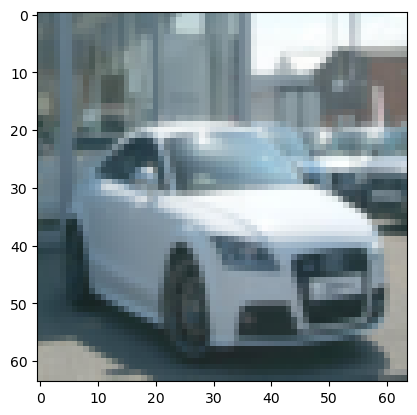

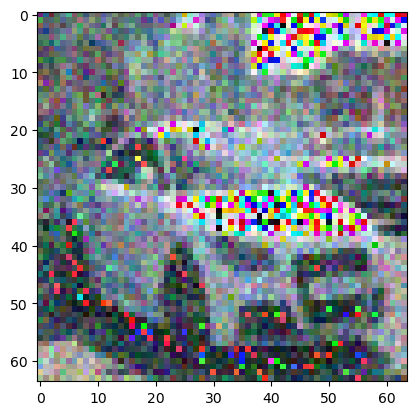

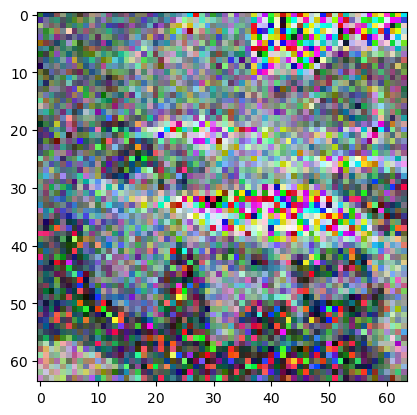

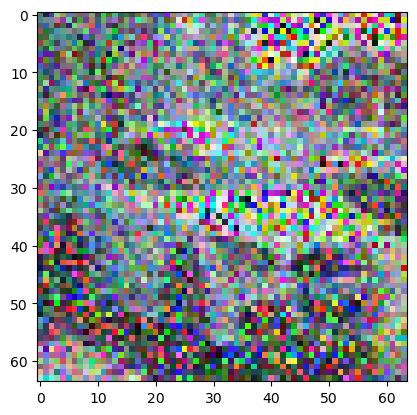

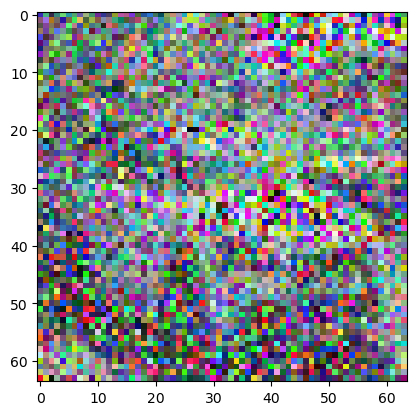

In [68]:
for img in noisy_images: 
    plt.imshow(reverse_transforms(img))
    plt.show()